<a href="https://colab.research.google.com/github/paton838/works/blob/master/data-science/share_predict/share_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# inspired by https://www.youtube.com/watch?v=QIUxPv5PJOY
#
%tensorflow_version 1.x
import math
import numpy as np
import pandas as pd

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
import datetime as dt
from datetime import datetime

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [0]:
# name of the share to be predicted
share_name = 'AIR.NZ'

In [3]:
# read in data
# data from Yahoo Finance
df = web.DataReader(share_name, data_source='yahoo', start='2005-01-01', end='2020-04-20')
print('Share price of {} the last 5 days:'.format(share_name))
print(df.tail())

Share price of AIR.NZ the last 5 days:
             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2020-04-14  1.220  1.070  1.090  1.180  15953003.0      1.180
2020-04-15  1.320  1.185  1.190  1.315  12900018.0      1.315
2020-04-16  1.610  1.270  1.330  1.310  17252975.0      1.310
2020-04-19  1.545  1.350  1.400  1.390   8768526.0      1.390
2020-04-20  1.485  1.330  1.405  1.360   6864236.0      1.360


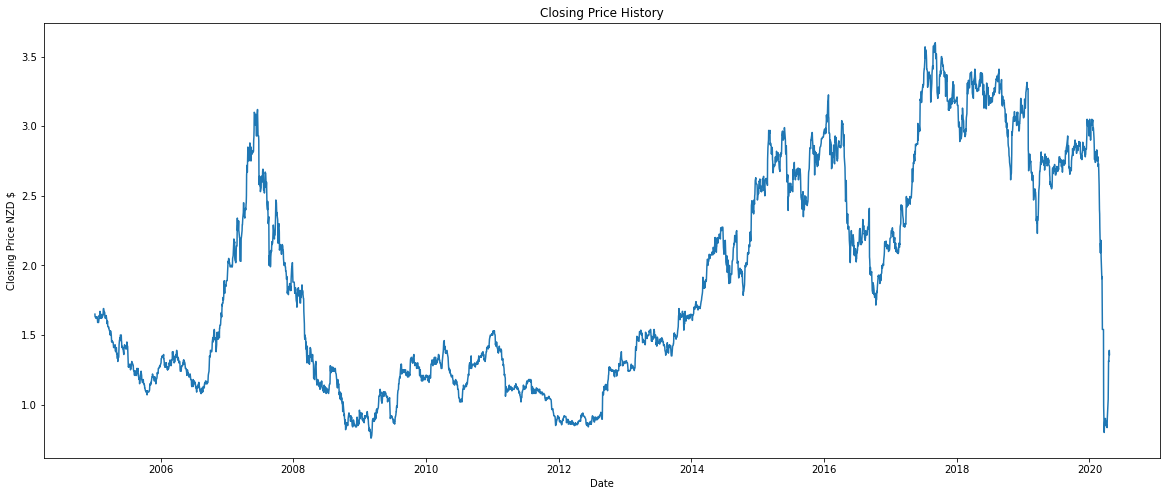

In [4]:
plt.figure(figsize=(20,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price NZD $')
plt.show()

In [5]:
# get the Closing price column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)

print("Number of days: {}".format(training_data_len))

Number of days: 3078


In [0]:
# scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# scaled_data

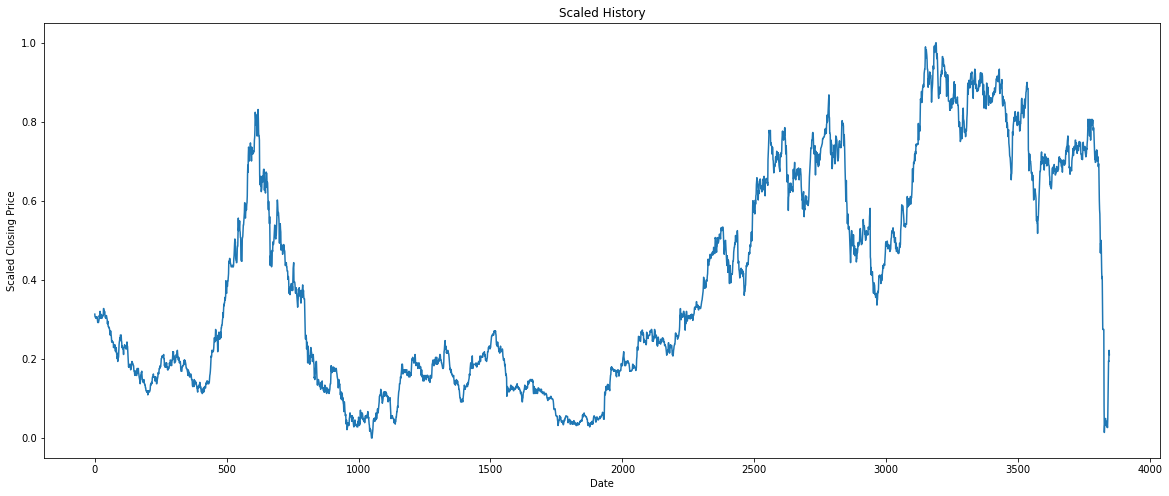

In [7]:
plt.figure(figsize=(20,8))
plt.title('Scaled History')
plt.plot(scaled_data)
plt.xlabel('Date')
plt.ylabel('Scaled Closing Price')
plt.show()

In [0]:
# use past 100 days to get trends
n_days_use = 100

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

# append each set of 'n_days_use' into x_train
for i in range(n_days_use, len(train_data)):
  x_train.append(train_data[i-n_days_use:i, 0])
  y_train.append(train_data[i, 0])

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(2978, 100, 1)


In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# using adam
# train model. best result = 0.08279703697189689

# model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
# using rmsprop
# train model. best result = 0.059735862305387855

model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [0]:
# using adamax
# train model. best result = 0.07695954650019605

# model.compile(optimizer='adamax', loss='mean_squared_error')

In [15]:
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
2978/2978 [==============================] - 156s 52ms/step - loss: 0.0014


In [0]:
# get the sets of 'n_days_use' to test
test_data = scaled_data[training_data_len - n_days_use: , :]

x_test = []
y_test = dataset[training_data_len: , :]
for i in range(n_days_use, len(test_data)):
  x_test.append(test_data[i-n_days_use:i, 0])

In [0]:
x_test = np.array(x_test)

In [0]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
# predict share price of the past
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [20]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.04521047913981662

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


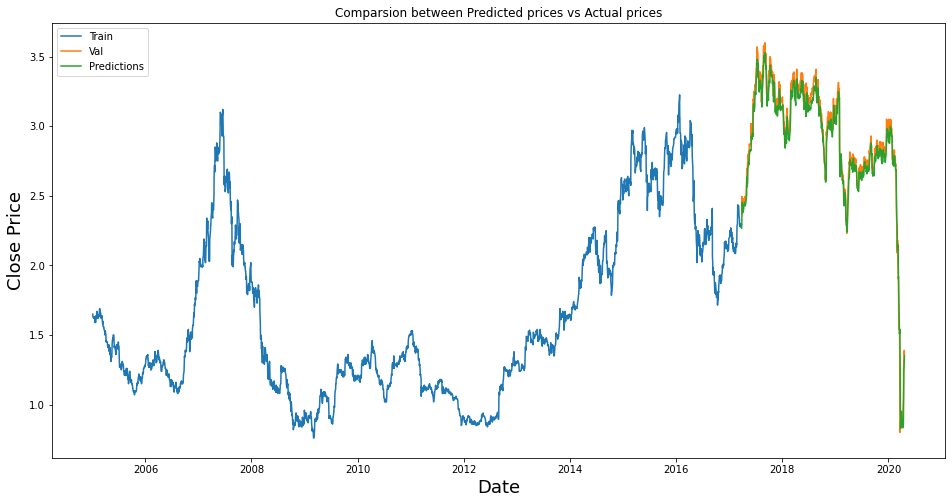

In [21]:
# plot to show the prediction and actual price

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Comparsion between Predicted prices vs Actual prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

In [22]:
# to ensure the Dataframe is making sense
valid.tail(5)

,Close,Predictions
Date,,
2020-04-14,1.180,0.953213
2020-04-15,1.315,1.088452
2020-04-16,1.310,1.235576
2020-04-19,1.390,1.305098
2020-04-20,1.360,1.352227


In [0]:
# Now, let's try to make some prediction of future days:
#=====================
# get the  quote
quote = df

In [0]:
#Create a new dataframe with only Close price
new_df = quote.filter(['Close'])

def predict_(df, n_days_use_=100):
  """ predict the price with a given df, and n_days_use (100 days by default). """
  # #Get the last n day closing price values and convert the dataframe to an array
  last_n_days = df[-n_days_use_:].values

  #Scale the data to be values between 0 and 1
  last_n_days_scaled = scaler.transform(last_n_days)
  #Create an empty list
  X_test = []
  #Append the past n days
  X_test.append(last_n_days_scaled)
  #Convert the X_test data set to a numpy array
  X_test = np.array(X_test)

  #Reshape the data
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  #Get the predicted scaled price
  pred_price = model.predict(X_test)

  #undo the scaling 
  pred_price = scaler.inverse_transform(pred_price)

  return pred_price

In [0]:
def print_ht(df, num):
  """ 
    Print the number of top and bottom items of df. 
    df: DataFrame to be printed
    num: Number of items to be printed out on head and tail
  """
  print(df.head(num))
  print(df.tail(num))

In [0]:
def get_prediction_value(df_to_predict):
  """ 
    Get the values from the prediction df. 
    df_to_predict: Dataframe to be used to get the predicted values.
  """
  return predict_(df_to_predict)[0][0]

In [0]:
def predict_append(df_a, n_days):
  """ 
    Append new data to the df, with n_days of future days to be predicted. 
    df_a: Dataframe with training values.
    n_days: num of future days to be predicted.
  """
  turn0_index = -1
  turn0_date = ''
  for i in range(n_days):
    # get new prediction
    new_prediction = get_prediction_value(df_a)

    # get the date of the next date
    next_date = pd.to_datetime( df_a.index[-1] + timedelta(days=1) ).date()
    # print(f'New date: {next_date}. Predicted price: {new_prediction}. ')

    # update df_a
    new_row = pd.DataFrame({'Close': new_prediction}, index=pd.to_datetime([next_date]))
    df_a = df_a.append(new_row)
    if (new_prediction <= 0) & (turn0_index == -1):
      turn0_index = i
      turn0_date = next_date
      # print(f'Turn 0 here::: Index: {turn0_index}, Date: {turn0_date}')
  return {'data':df_a, 'turn0': [turn0_index, turn0_date]}

In [28]:
# try predicting the next 5 days
days_to_predict = 5

predicted_future = predict_append(new_df, days_to_predict)
predicted_days = ( predicted_future )['data'].iloc[-days_to_predict:, :]

print("Share price of {} on the future {} days from the data we obtained.".format(share_name, days_to_predict))
print(predicted_days)
print(predicted_days.shape)

# print(list(predicted_future)[:])
# (predicted_future)

# to print out the day that it's predicted to reach 0
# print(f'Date turn 0: {predicted_future["turn0"][0]}, {predicted_future["turn0"][1]}')

Share price of AIR.NZ on the future 5 days from the data we obtained.
               Close
2020-04-21  1.346961
2020-04-22  1.319815
2020-04-23  1.286453
2020-04-24  1.254326
2020-04-25  1.227597
(5, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


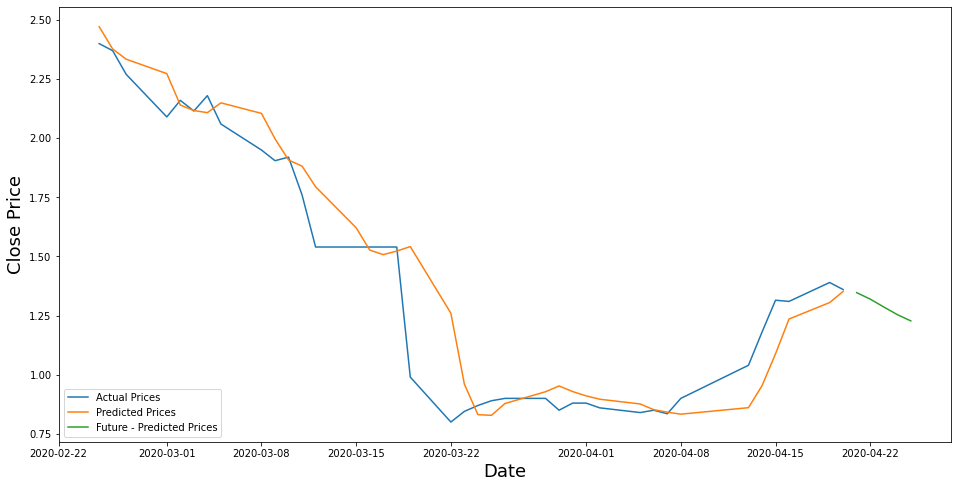

In [29]:
# Let's show the data on a chart:

# only show the latest 5% of the training (past) data
# train = data[math.ceil(training_data_len*0.95):]
# valid = data[training_data_len:]

# the actual prices. show only the latest 5% data.
valid = data[training_data_len + math.ceil(len(predictions) * 0.95):]

# the predicted prices of the past days. show only the latest 5% data.
valid['Predictions'] = predictions[math.ceil(len(predictions) * 0.95):]

# the predicted prices of the future days
future = predicted_days

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
# plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(future['Close'])

## if the predicted price ever goes below 0
# plt.annotate(f'Turn 0 @{predicted_future["turn0"][1]}!', xy=[predicted_future["turn0"][1], 0]
#               , xytext=(pd.Timestamp('2019-01-01'), 0.5)
#               , arrowprops={'arrowstyle':'->', 'color':'red'})

# plt.legend(['Train', 'Val', 'Predictions', 'Future'], loc='lower left')
plt.legend(['Actual Prices', 'Predicted Prices', 'Future - Predicted Prices'], loc='lower left')
plt.show()

In [30]:
# Actual Prices
future

,Close
2020-04-21,1.346961
2020-04-22,1.319815
2020-04-23,1.286453
2020-04-24,1.254326
2020-04-25,1.227597


In [31]:
# the actual price of the last few days
quote2 = web.DataReader(share_name, data_source='yahoo', start='2020-04-21', end='2020-04-25')
print(quote2['Close'])

Date
2020-04-20    1.360
2020-04-21    1.275
2020-04-22    1.280
2020-04-23    1.205
Name: Close, dtype: float64


In [32]:
valid.tail(10)

,Close,Predictions
Date,,
2020-04-05,0.840,0.876396
2020-04-06,0.850,0.852081
2020-04-07,0.835,0.841748
2020-04-08,0.900,0.833194
2020-04-13,1.040,0.860692
2020-04-14,1.180,0.953213
2020-04-15,1.315,1.088452
2020-04-16,1.310,1.235576
2020-04-19,1.390,1.305098
